# Comparison between sklearn's and gensim's implementations of NMF

In [1]:
%load_ext line_profiler
%load_ext autoreload

%autoreload 2

from gensim.models.nmf import Nmf as GensimNmf
from gensim.models import CoherenceModel, LdaModel
from gensim.parsing.preprocessing import preprocess_documents
from gensim import matutils
from sklearn.decomposition.nmf import NMF as SklearnNmf
import sklearn.decomposition.nmf
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from matplotlib import pyplot as plt

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# 20newsgroups

In [2]:
from gensim.parsing.preprocessing import preprocess_documents

documents = preprocess_documents(fetch_20newsgroups().data[:1000])

In [3]:
from gensim.corpora import Dictionary

dictionary = Dictionary(documents)

dictionary.filter_extremes()

2018-08-27 21:58:39,992 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-08-27 21:58:40,232 : INFO : built Dictionary(17622 unique tokens: ['addit', 'bodi', 'bricklin', 'brought', 'bumper']...) from 1000 documents (total 136081 corpus positions)
2018-08-27 21:58:40,262 : INFO : discarding 14411 tokens: [('bricklin', 2), ('bumper', 4), ('edu', 661), ('funki', 4), ('lerxst', 2), ('line', 989), ('organ', 952), ('rac', 1), ('subject', 1000), ('tellm', 2)]...
2018-08-27 21:58:40,263 : INFO : keeping 3211 tokens which were in no less than 5 and no more than 500 (=50.0%) documents
2018-08-27 21:58:40,275 : INFO : resulting dictionary: Dictionary(3211 unique tokens: ['addit', 'bodi', 'brought', 'call', 'car']...)


In [4]:
corpus = [
    dictionary.doc2bow(document)
    for document
    in documents
]

bow_matrix = matutils.corpus2dense(corpus, len(dictionary), len(documents))
proba_bow_matrix = bow_matrix / bow_matrix.sum(axis=0)

## Sklearn NMF

In [5]:
%%time

sklearn_nmf = SklearnNmf(n_components=5, tol=1e-5, max_iter=int(1e9), random_state=42)

W = sklearn_nmf.fit_transform(proba_bow_matrix)
H = sklearn_nmf.components_

CPU times: user 4.18 s, sys: 1.59 s, total: 5.77 s
Wall time: 1.68 s


In [6]:
np.linalg.norm(proba_bow_matrix - W.dot(H), 'fro')

5.4196922866931585

In [60]:
training_params = dict(
    corpus=corpus,
    num_topics=5,
    id2word=dictionary,
    passes=5,
    eval_every=10,
    minimum_probability=0
)

## Gensim NMF

In [62]:
%%time

np.random.seed(42)

gensim_nmf = GensimNmf(**training_params)

2018-08-27 23:26:31,349 : INFO : h_r_error: 225977.5
2018-08-27 23:26:31,452 : INFO : h_r_error: 221992.53713113835
2018-08-27 23:26:31,571 : INFO : h_r_error: 221285.49541543392
2018-08-27 23:26:31,759 : INFO : w_error: 221075.77007477023
2018-08-27 23:26:31,854 : INFO : w_error: 191005.38242945526
2018-08-27 23:26:31,949 : INFO : w_error: 183765.66879017078
2018-08-27 23:26:32,046 : INFO : w_error: 180425.77156255016
2018-08-27 23:26:32,151 : INFO : w_error: 178840.1919094708
2018-08-27 23:26:32,261 : INFO : w_error: 178033.61304943197
2018-08-27 23:26:32,372 : INFO : w_error: 177582.7125470111
2018-08-27 23:26:32,487 : INFO : w_error: 177299.19369733552
2018-08-27 23:26:32,591 : INFO : w_error: 177100.1820181257
2018-08-27 23:26:32,696 : INFO : w_error: 176950.44069854
2018-08-27 23:26:32,801 : INFO : w_error: 176829.47586924737
2018-08-27 23:26:32,907 : INFO : w_error: 176728.64394216385
2018-08-27 23:26:33,005 : INFO : w_error: 176643.19544533442
2018-08-27 23:26:33,108 : INFO : w

CPU times: user 13.4 s, sys: 18.1 s, total: 31.5 s
Wall time: 11.7 s


In [64]:
%%time

np.random.seed(42)

lda = LdaModel(**training_params)

2018-08-27 23:29:25,583 : INFO : using symmetric alpha at 0.2
2018-08-27 23:29:25,584 : INFO : using symmetric eta at 0.2
2018-08-27 23:29:25,588 : INFO : using serial LDA version on this node
2018-08-27 23:29:25,591 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 1000 documents, updating model once every 1000 documents, evaluating perplexity every 1000 documents, iterating 50x with a convergence threshold of 0.001000
2018-08-27 23:29:25,592 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2018-08-27 23:29:26,702 : INFO : -8.721 per-word bound, 422.1 perplexity estimate based on a held-out corpus of 1000 documents with 99435 words
2018-08-27 23:29:26,702 : INFO : PROGRESS: pass 0, at document #1000/1000
2018-08-27 23:29:27,508 : INFO : topic #0 (0.200): 0.009*"articl" + 0.007*"com" + 0.006*"window" + 0.006*"univers" + 0.006*"post" + 0.005*"time" + 0.005*

CPU times: user 9.59 s, sys: 0 ns, total: 9.59 s
Wall time: 9.59 s


In [65]:
gensim_cm = CoherenceModel(
    model=gensim_nmf,
    corpus=corpus,
    coherence='u_mass'
)

gensim_cm.get_coherence()

2018-08-27 23:29:48,650 : INFO : CorpusAccumulator accumulated stats from 1000 documents


-2.1572860157511426

In [66]:
lda_cm = CoherenceModel(
    model=lda,
    corpus=corpus,
    coherence='u_mass'
)

lda_cm.get_coherence()

2018-08-27 23:29:49,502 : INFO : CorpusAccumulator accumulated stats from 1000 documents


-1.6429322091255478

In [88]:
def perplexity(model, corpus):
    W = gensim_nmf.get_topics().T

    H = np.zeros((W.shape[1], len(corpus)))
    for bow_id, bow in enumerate(corpus):
        for topic_id, proba in model[bow]:
            H[topic_id, bow_id] = proba
    
    dense_corpus = matutils.corpus2dense(corpus, W.shape[0])
    
    return np.exp(-(np.log(W.dot(H), where=W.dot(H)>0) * dense_corpus).sum() / dense_corpus.sum())

In [89]:
perplexity(gensim_nmf, corpus)

2018-08-27 23:45:03,036 : INFO : h_r_error: 98.15428401565417
2018-08-27 23:45:03,042 : INFO : h_r_error: 34.204954619573016
2018-08-27 23:45:03,047 : INFO : h_r_error: 34.148179145306976
2018-08-27 23:45:03,052 : INFO : h_r_error: 34.148179145306976
2018-08-27 23:45:03,056 : INFO : h_r_error: 55.15774665060254
2018-08-27 23:45:03,060 : INFO : h_r_error: 55.09247751204706
2018-08-27 23:45:03,064 : INFO : h_r_error: 55.09247751204706
2018-08-27 23:45:03,089 : INFO : h_r_error: 98.50135185634834
2018-08-27 23:45:03,094 : INFO : h_r_error: 98.15428401565417
2018-08-27 23:45:03,102 : INFO : h_r_error: 98.15428401565417
2018-08-27 23:45:03,105 : INFO : h_r_error: 41.28375617822966
2018-08-27 23:45:03,109 : INFO : h_r_error: 41.18009326469662
2018-08-27 23:45:03,113 : INFO : h_r_error: 41.18009326469662
2018-08-27 23:45:03,119 : INFO : h_r_error: 55.258363251443434
2018-08-27 23:45:03,123 : INFO : h_r_error: 55.16669694155178
2018-08-27 23:45:03,129 : INFO : h_r_error: 55.16669694155178
2018

2018-08-27 23:45:03,765 : INFO : h_r_error: 69.25859673718531
2018-08-27 23:45:03,769 : INFO : h_r_error: 69.07631486664287
2018-08-27 23:45:03,772 : INFO : h_r_error: 69.07631486664287
2018-08-27 23:45:03,782 : INFO : h_r_error: 22.063284645279
2018-08-27 23:45:03,785 : INFO : h_r_error: 22.02693299183024
2018-08-27 23:45:03,787 : INFO : h_r_error: 22.02693299183024
2018-08-27 23:45:03,789 : INFO : h_r_error: 41.53473479257632
2018-08-27 23:45:03,792 : INFO : h_r_error: 41.45689474805954
2018-08-27 23:45:03,794 : INFO : h_r_error: 41.45689474805954
2018-08-27 23:45:03,796 : INFO : h_r_error: 94.75813969743993
2018-08-27 23:45:03,799 : INFO : h_r_error: 94.63834747986454
2018-08-27 23:45:03,801 : INFO : h_r_error: 94.63834747986454
2018-08-27 23:45:03,803 : INFO : h_r_error: 53.54044869001222
2018-08-27 23:45:03,805 : INFO : h_r_error: 53.247721498899615
2018-08-27 23:45:03,808 : INFO : h_r_error: 53.247721498899615
2018-08-27 23:45:03,812 : INFO : h_r_error: 16.42071107666247
2018-08-

2018-08-27 23:45:04,350 : INFO : h_r_error: 172.55845431899172
2018-08-27 23:45:04,361 : INFO : h_r_error: 25.884914833774886
2018-08-27 23:45:04,368 : INFO : h_r_error: 25.822460180952838
2018-08-27 23:45:04,371 : INFO : h_r_error: 25.822460180952838
2018-08-27 23:45:04,375 : INFO : h_r_error: 38.76063887209145
2018-08-27 23:45:04,378 : INFO : h_r_error: 38.76063887209145
2018-08-27 23:45:04,379 : INFO : h_r_error: 326.07969479087296
2018-08-27 23:45:04,382 : INFO : h_r_error: 325.3908992600763
2018-08-27 23:45:04,384 : INFO : h_r_error: 325.3908992600763
2018-08-27 23:45:04,386 : INFO : h_r_error: 35.91784836580319
2018-08-27 23:45:04,388 : INFO : h_r_error: 35.807358439079145
2018-08-27 23:45:04,391 : INFO : h_r_error: 35.807358439079145
2018-08-27 23:45:04,394 : INFO : h_r_error: 19.13148079768309
2018-08-27 23:45:04,396 : INFO : h_r_error: 19.106338684559624
2018-08-27 23:45:04,398 : INFO : h_r_error: 19.106338684559624
2018-08-27 23:45:04,401 : INFO : h_r_error: 30.54882445898526

2018-08-27 23:45:04,778 : INFO : h_r_error: 51.557964045313064
2018-08-27 23:45:04,781 : INFO : h_r_error: 51.50323473393472
2018-08-27 23:45:04,785 : INFO : h_r_error: 51.50323473393472
2018-08-27 23:45:04,786 : INFO : h_r_error: 375.5958407200147
2018-08-27 23:45:04,794 : INFO : h_r_error: 375.5958407200147
2018-08-27 23:45:04,804 : INFO : h_r_error: 59.30199953901197
2018-08-27 23:45:04,806 : INFO : h_r_error: 59.19505862613608
2018-08-27 23:45:04,808 : INFO : h_r_error: 59.19505862613608
2018-08-27 23:45:04,810 : INFO : h_r_error: 81.09605110179356
2018-08-27 23:45:04,814 : INFO : h_r_error: 80.92624684791024
2018-08-27 23:45:04,821 : INFO : h_r_error: 80.92624684791024
2018-08-27 23:45:04,823 : INFO : h_r_error: 0.12451997498887594
2018-08-27 23:45:04,826 : INFO : h_r_error: 0.06254923862768746
2018-08-27 23:45:04,836 : INFO : h_r_error: 0.06254923862768746
2018-08-27 23:45:04,842 : INFO : h_r_error: 279.7162441491524
2018-08-27 23:45:04,844 : INFO : h_r_error: 278.5133132996239
2

2018-08-27 23:45:05,194 : INFO : h_r_error: 80.40671792920304
2018-08-27 23:45:05,202 : INFO : h_r_error: 80.40671792920304
2018-08-27 23:45:05,204 : INFO : h_r_error: 100.25368008543657
2018-08-27 23:45:05,205 : INFO : h_r_error: 100.00731675409415
2018-08-27 23:45:05,211 : INFO : h_r_error: 100.00731675409415
2018-08-27 23:45:05,218 : INFO : h_r_error: 89.08353563367831
2018-08-27 23:45:05,225 : INFO : h_r_error: 88.88437664497803
2018-08-27 23:45:05,228 : INFO : h_r_error: 88.88437664497803
2018-08-27 23:45:05,231 : INFO : h_r_error: 39.624592449996385
2018-08-27 23:45:05,235 : INFO : h_r_error: 39.624592449996385
2018-08-27 23:45:05,242 : INFO : h_r_error: 76.1784936796049
2018-08-27 23:45:05,243 : INFO : h_r_error: 76.10054579189001
2018-08-27 23:45:05,245 : INFO : h_r_error: 76.10054579189001
2018-08-27 23:45:05,247 : INFO : h_r_error: 32.19508197934453
2018-08-27 23:45:05,249 : INFO : h_r_error: 32.11345417491875
2018-08-27 23:45:05,256 : INFO : h_r_error: 32.11345417491875
2018

2018-08-27 23:45:05,596 : INFO : h_r_error: 16.83022865186834
2018-08-27 23:45:05,600 : INFO : h_r_error: 16.83022865186834
2018-08-27 23:45:05,602 : INFO : h_r_error: 76.90450482825301
2018-08-27 23:45:05,612 : INFO : h_r_error: 76.76267688860051
2018-08-27 23:45:05,614 : INFO : h_r_error: 76.76267688860051
2018-08-27 23:45:05,617 : INFO : h_r_error: 26.055473328561543
2018-08-27 23:45:05,619 : INFO : h_r_error: 26.020126327410722
2018-08-27 23:45:05,624 : INFO : h_r_error: 26.020126327410722
2018-08-27 23:45:05,626 : INFO : h_r_error: 15.114050406012161
2018-08-27 23:45:05,628 : INFO : h_r_error: 15.096934745237116
2018-08-27 23:45:05,633 : INFO : h_r_error: 15.096934745237116
2018-08-27 23:45:05,640 : INFO : h_r_error: 25.979249064709784
2018-08-27 23:45:05,644 : INFO : h_r_error: 25.979249064709784
2018-08-27 23:45:05,645 : INFO : h_r_error: 29.8061847244872
2018-08-27 23:45:05,648 : INFO : h_r_error: 29.8061847244872
2018-08-27 23:45:05,650 : INFO : h_r_error: 52.84119446390539
20

2018-08-27 23:45:06,164 : INFO : h_r_error: 50.440106981337415
2018-08-27 23:45:06,166 : INFO : h_r_error: 50.254724132608246
2018-08-27 23:45:06,172 : INFO : h_r_error: 50.254724132608246
2018-08-27 23:45:06,174 : INFO : h_r_error: 19.340362349877598
2018-08-27 23:45:06,178 : INFO : h_r_error: 19.340362349877598
2018-08-27 23:45:06,186 : INFO : h_r_error: 27.70996952427579
2018-08-27 23:45:06,188 : INFO : h_r_error: 27.6464740101641
2018-08-27 23:45:06,195 : INFO : h_r_error: 27.6464740101641
2018-08-27 23:45:06,202 : INFO : h_r_error: 39.34625996403188
2018-08-27 23:45:06,205 : INFO : h_r_error: 39.34625996403188
2018-08-27 23:45:06,208 : INFO : h_r_error: 33.10212029224958
2018-08-27 23:45:06,211 : INFO : h_r_error: 32.99430139672799
2018-08-27 23:45:06,214 : INFO : h_r_error: 32.99430139672799
2018-08-27 23:45:06,216 : INFO : h_r_error: 46.07887389967507
2018-08-27 23:45:06,218 : INFO : h_r_error: 46.01851588024032
2018-08-27 23:45:06,221 : INFO : h_r_error: 46.01851588024032
2018-

2018-08-27 23:45:06,521 : INFO : h_r_error: 48.870374115562875
2018-08-27 23:45:06,523 : INFO : h_r_error: 48.80457665707309
2018-08-27 23:45:06,524 : INFO : h_r_error: 48.80457665707309
2018-08-27 23:45:06,525 : INFO : h_r_error: 35.74502855493133
2018-08-27 23:45:06,527 : INFO : h_r_error: 35.57787192915626
2018-08-27 23:45:06,529 : INFO : h_r_error: 35.57787192915626
2018-08-27 23:45:06,530 : INFO : h_r_error: 48.18625849017527
2018-08-27 23:45:06,532 : INFO : h_r_error: 48.04901727078026
2018-08-27 23:45:06,533 : INFO : h_r_error: 48.04901727078026
2018-08-27 23:45:06,535 : INFO : h_r_error: 52.86837858909793
2018-08-27 23:45:06,537 : INFO : h_r_error: 52.86837858909793
2018-08-27 23:45:06,538 : INFO : h_r_error: 20.257427128731027
2018-08-27 23:45:06,540 : INFO : h_r_error: 20.257427128731027
2018-08-27 23:45:06,541 : INFO : h_r_error: 65.57066210251112
2018-08-27 23:45:06,542 : INFO : h_r_error: 65.57066210251112
2018-08-27 23:45:06,544 : INFO : h_r_error: 10.480831776998496
2018

2018-08-27 23:45:06,884 : INFO : h_r_error: 44.17078675617944
2018-08-27 23:45:06,886 : INFO : h_r_error: 44.039771212550974
2018-08-27 23:45:06,888 : INFO : h_r_error: 44.039771212550974
2018-08-27 23:45:06,890 : INFO : h_r_error: 213.9284918964127
2018-08-27 23:45:06,891 : INFO : h_r_error: 208.51058417211948
2018-08-27 23:45:06,893 : INFO : h_r_error: 208.51058417211948
2018-08-27 23:45:06,895 : INFO : h_r_error: 29.174511718818835
2018-08-27 23:45:06,898 : INFO : h_r_error: 29.174511718818835
2018-08-27 23:45:06,900 : INFO : h_r_error: 28.84894596136431
2018-08-27 23:45:06,901 : INFO : h_r_error: 28.814036561553365
2018-08-27 23:45:06,903 : INFO : h_r_error: 28.814036561553365
2018-08-27 23:45:06,904 : INFO : h_r_error: 47.65804740525725
2018-08-27 23:45:06,906 : INFO : h_r_error: 47.5779877472347
2018-08-27 23:45:06,908 : INFO : h_r_error: 47.5779877472347
2018-08-27 23:45:06,909 : INFO : h_r_error: 135.9279038949289
2018-08-27 23:45:06,911 : INFO : h_r_error: 135.6096671792661
20

2018-08-27 23:45:07,347 : INFO : h_r_error: 10.960875108494276
2018-08-27 23:45:07,349 : INFO : h_r_error: 20.30603870171832
2018-08-27 23:45:07,355 : INFO : h_r_error: 20.30603870171832
2018-08-27 23:45:07,359 : INFO : h_r_error: 14.418812106181255
2018-08-27 23:45:07,361 : INFO : h_r_error: 14.418812106181255
2018-08-27 23:45:07,368 : INFO : h_r_error: 173.28984849383568
2018-08-27 23:45:07,369 : INFO : h_r_error: 172.98807336926097
2018-08-27 23:45:07,371 : INFO : h_r_error: 172.98807336926097
2018-08-27 23:45:07,372 : INFO : h_r_error: 4.969974345154891
2018-08-27 23:45:07,379 : INFO : h_r_error: 4.969974345154891
2018-08-27 23:45:07,381 : INFO : h_r_error: 26.30796703135781
2018-08-27 23:45:07,383 : INFO : h_r_error: 26.30796703135781
2018-08-27 23:45:07,384 : INFO : h_r_error: 16.759315011255314
2018-08-27 23:45:07,386 : INFO : h_r_error: 16.737119025489264
2018-08-27 23:45:07,397 : INFO : h_r_error: 16.737119025489264
2018-08-27 23:45:07,398 : INFO : h_r_error: 20.78461286256328

2018-08-27 23:45:07,728 : INFO : h_r_error: 158.37195275428323
2018-08-27 23:45:07,729 : INFO : h_r_error: 40.38739650927441
2018-08-27 23:45:07,733 : INFO : h_r_error: 40.38739650927441
2018-08-27 23:45:07,746 : INFO : h_r_error: 59.42316719875138
2018-08-27 23:45:07,747 : INFO : h_r_error: 59.359176731568546
2018-08-27 23:45:07,750 : INFO : h_r_error: 59.359176731568546
2018-08-27 23:45:07,768 : INFO : h_r_error: 77.95379990476026
2018-08-27 23:45:07,770 : INFO : h_r_error: 77.95379990476026
2018-08-27 23:45:07,779 : INFO : h_r_error: 118.23252018671822
2018-08-27 23:45:07,781 : INFO : h_r_error: 118.23252018671822
2018-08-27 23:45:07,782 : INFO : h_r_error: 25.88307418156134
2018-08-27 23:45:07,784 : INFO : h_r_error: 25.88307418156134
2018-08-27 23:45:07,785 : INFO : h_r_error: 45.941393512918324
2018-08-27 23:45:07,787 : INFO : h_r_error: 45.860389244768996
2018-08-27 23:45:07,796 : INFO : h_r_error: 45.860389244768996
2018-08-27 23:45:07,798 : INFO : h_r_error: 41.33847123777973


2018-08-27 23:45:08,140 : INFO : h_r_error: 502.6872839186179
2018-08-27 23:45:08,142 : INFO : h_r_error: 497.5350447373528
2018-08-27 23:45:08,144 : INFO : h_r_error: 497.5350447373528
2018-08-27 23:45:08,147 : INFO : h_r_error: 82.2205372739174
2018-08-27 23:45:08,150 : INFO : h_r_error: 82.09579936407765
2018-08-27 23:45:08,155 : INFO : h_r_error: 82.09579936407765
2018-08-27 23:45:08,158 : INFO : h_r_error: 366.208574378532
2018-08-27 23:45:08,160 : INFO : h_r_error: 365.51900168356025
2018-08-27 23:45:08,162 : INFO : h_r_error: 365.51900168356025
2018-08-27 23:45:08,165 : INFO : h_r_error: 65.73062245409207
2018-08-27 23:45:08,168 : INFO : h_r_error: 65.6287930641892
2018-08-27 23:45:08,170 : INFO : h_r_error: 65.6287930641892
2018-08-27 23:45:08,178 : INFO : h_r_error: 247.04895087780181
2018-08-27 23:45:08,182 : INFO : h_r_error: 246.02424396933856
2018-08-27 23:45:08,185 : INFO : h_r_error: 246.02424396933856
2018-08-27 23:45:08,190 : INFO : h_r_error: 331.02211616833677
2018-0

2018-08-27 23:45:08,797 : INFO : h_r_error: 54.20588507641205
2018-08-27 23:45:08,808 : INFO : h_r_error: 25.239972619118518
2018-08-27 23:45:08,812 : INFO : h_r_error: 25.239972619118518
2018-08-27 23:45:08,814 : INFO : h_r_error: 779.1560778667736
2018-08-27 23:45:08,816 : INFO : h_r_error: 751.8088675662666
2018-08-27 23:45:08,819 : INFO : h_r_error: 751.8088675662666
2018-08-27 23:45:08,821 : INFO : h_r_error: 293.49057327736494
2018-08-27 23:45:08,823 : INFO : h_r_error: 292.2370697339675
2018-08-27 23:45:08,825 : INFO : h_r_error: 292.2370697339675
2018-08-27 23:45:08,835 : INFO : h_r_error: 37.18396834043754
2018-08-27 23:45:08,858 : INFO : h_r_error: 37.06869871444631
2018-08-27 23:45:08,860 : INFO : h_r_error: 37.06869871444631
2018-08-27 23:45:08,862 : INFO : h_r_error: 15.394499804641221
2018-08-27 23:45:08,866 : INFO : h_r_error: 15.346255030161108
2018-08-27 23:45:08,880 : INFO : h_r_error: 15.346255030161108
2018-08-27 23:45:08,884 : INFO : h_r_error: 64.70430837598282
20

2018-08-27 23:45:09,309 : INFO : h_r_error: 90.72532178722821
2018-08-27 23:45:09,312 : INFO : h_r_error: 90.61667122330805
2018-08-27 23:45:09,320 : INFO : h_r_error: 90.61667122330805
2018-08-27 23:45:09,322 : INFO : h_r_error: 32.473202718187586
2018-08-27 23:45:09,324 : INFO : h_r_error: 32.43099032072294
2018-08-27 23:45:09,333 : INFO : h_r_error: 32.43099032072294
2018-08-27 23:45:09,335 : INFO : h_r_error: 55.26154019629022
2018-08-27 23:45:09,338 : INFO : h_r_error: 55.26154019629022
2018-08-27 23:45:09,340 : INFO : h_r_error: 103.75728803890173
2018-08-27 23:45:09,342 : INFO : h_r_error: 103.25373949633641
2018-08-27 23:45:09,345 : INFO : h_r_error: 103.25373949633641
2018-08-27 23:45:09,347 : INFO : h_r_error: 14.427678979980671
2018-08-27 23:45:09,350 : INFO : h_r_error: 14.427678979980671
2018-08-27 23:45:09,352 : INFO : h_r_error: 37.026167019192364
2018-08-27 23:45:09,354 : INFO : h_r_error: 36.92301663711912
2018-08-27 23:45:09,357 : INFO : h_r_error: 36.92301663711912
2

2018-08-27 23:45:09,929 : INFO : h_r_error: 53.85500726024805
2018-08-27 23:45:09,937 : INFO : h_r_error: 131.7840283928187
2018-08-27 23:45:09,943 : INFO : h_r_error: 131.37100202071076
2018-08-27 23:45:09,946 : INFO : h_r_error: 131.37100202071076
2018-08-27 23:45:09,949 : INFO : h_r_error: 84.53023850255838
2018-08-27 23:45:09,951 : INFO : h_r_error: 84.29000882473328
2018-08-27 23:45:09,954 : INFO : h_r_error: 84.29000882473328
2018-08-27 23:45:09,957 : INFO : h_r_error: 40.02804697059197
2018-08-27 23:45:09,959 : INFO : h_r_error: 39.98781253201647
2018-08-27 23:45:09,962 : INFO : h_r_error: 39.98781253201647
2018-08-27 23:45:09,965 : INFO : h_r_error: 351.2919620615984
2018-08-27 23:45:09,967 : INFO : h_r_error: 347.7451589124805
2018-08-27 23:45:09,975 : INFO : h_r_error: 347.7451589124805
2018-08-27 23:45:09,987 : INFO : h_r_error: 85.80607509073015
2018-08-27 23:45:09,990 : INFO : h_r_error: 85.38998726416797
2018-08-27 23:45:09,992 : INFO : h_r_error: 85.38998726416797
2018-0

2018-08-27 23:45:10,595 : INFO : h_r_error: 41.71689134406895
2018-08-27 23:45:10,608 : INFO : h_r_error: 41.71689134406895
2018-08-27 23:45:10,614 : INFO : h_r_error: 108.03321989463547
2018-08-27 23:45:10,621 : INFO : h_r_error: 107.84606871061298
2018-08-27 23:45:10,626 : INFO : h_r_error: 107.84606871061298
2018-08-27 23:45:10,629 : INFO : h_r_error: 112.68078163239812
2018-08-27 23:45:10,633 : INFO : h_r_error: 112.182702555122
2018-08-27 23:45:10,643 : INFO : h_r_error: 112.182702555122
2018-08-27 23:45:10,645 : INFO : h_r_error: 10.891440732753185
2018-08-27 23:45:10,648 : INFO : h_r_error: 10.880070013624625
2018-08-27 23:45:10,650 : INFO : h_r_error: 10.880070013624625
2018-08-27 23:45:10,656 : INFO : h_r_error: 137.15990057875675
2018-08-27 23:45:10,662 : INFO : h_r_error: 136.66579590761867
2018-08-27 23:45:10,665 : INFO : h_r_error: 136.66579590761867
2018-08-27 23:45:10,668 : INFO : h_r_error: 51.14945240147144
2018-08-27 23:45:10,675 : INFO : h_r_error: 50.94589800612068


2018-08-27 23:45:11,101 : INFO : h_r_error: 54.791163939138166
2018-08-27 23:45:11,105 : INFO : h_r_error: 54.791163939138166
2018-08-27 23:45:11,107 : INFO : h_r_error: 71.28003141174423
2018-08-27 23:45:11,109 : INFO : h_r_error: 71.28003141174423
2018-08-27 23:45:11,111 : INFO : h_r_error: 278.7892511784869
2018-08-27 23:45:11,113 : INFO : h_r_error: 277.8740514173475
2018-08-27 23:45:11,116 : INFO : h_r_error: 277.8740514173475
2018-08-27 23:45:11,149 : INFO : h_r_error: 38.33404340328102
2018-08-27 23:45:11,154 : INFO : h_r_error: 37.94848644040294
2018-08-27 23:45:11,157 : INFO : h_r_error: 37.94848644040294
2018-08-27 23:45:11,160 : INFO : h_r_error: 87.53207584347362
2018-08-27 23:45:11,162 : INFO : h_r_error: 87.42255108756697
2018-08-27 23:45:11,165 : INFO : h_r_error: 87.42255108756697
2018-08-27 23:45:11,168 : INFO : h_r_error: 219.70159995282586
2018-08-27 23:45:11,174 : INFO : h_r_error: 218.47045457251707
2018-08-27 23:45:11,182 : INFO : h_r_error: 218.47045457251707
201

2018-08-27 23:45:11,719 : INFO : h_r_error: 45.401771414252345
2018-08-27 23:45:11,721 : INFO : h_r_error: 45.401771414252345
2018-08-27 23:45:11,726 : INFO : h_r_error: 30.074611573855023
2018-08-27 23:45:11,731 : INFO : h_r_error: 30.035124149185776
2018-08-27 23:45:11,734 : INFO : h_r_error: 30.035124149185776
2018-08-27 23:45:11,736 : INFO : h_r_error: 212.84477695033883
2018-08-27 23:45:11,741 : INFO : h_r_error: 212.28267152956136
2018-08-27 23:45:11,745 : INFO : h_r_error: 212.28267152956136
2018-08-27 23:45:11,746 : INFO : h_r_error: 220.1495256469164
2018-08-27 23:45:11,750 : INFO : h_r_error: 219.46351890529186
2018-08-27 23:45:11,752 : INFO : h_r_error: 219.46351890529186
2018-08-27 23:45:11,754 : INFO : h_r_error: 109.64399896023605
2018-08-27 23:45:11,757 : INFO : h_r_error: 109.42629761648602
2018-08-27 23:45:11,759 : INFO : h_r_error: 109.42629761648602
2018-08-27 23:45:11,761 : INFO : h_r_error: 24.713960627006085
2018-08-27 23:45:11,763 : INFO : h_r_error: 24.663537385

2018-08-27 23:45:12,067 : INFO : h_r_error: 22.637724257834467
2018-08-27 23:45:12,069 : INFO : h_r_error: 22.637724257834467
2018-08-27 23:45:12,070 : INFO : h_r_error: 39.71471153241762
2018-08-27 23:45:12,072 : INFO : h_r_error: 39.64931448273663
2018-08-27 23:45:12,073 : INFO : h_r_error: 39.64931448273663
2018-08-27 23:45:12,076 : INFO : h_r_error: 64.93648605789367
2018-08-27 23:45:12,078 : INFO : h_r_error: 64.44710543890649
2018-08-27 23:45:12,082 : INFO : h_r_error: 64.44710543890649
2018-08-27 23:45:12,083 : INFO : h_r_error: 112.21119587544713
2018-08-27 23:45:12,091 : INFO : h_r_error: 111.97552549702522
2018-08-27 23:45:12,094 : INFO : h_r_error: 111.97552549702522
2018-08-27 23:45:12,098 : INFO : h_r_error: 56.77863023203744
2018-08-27 23:45:12,101 : INFO : h_r_error: 56.71698210531082
2018-08-27 23:45:12,103 : INFO : h_r_error: 56.71698210531082
2018-08-27 23:45:12,118 : INFO : h_r_error: 75.79728742391968
2018-08-27 23:45:12,123 : INFO : h_r_error: 75.68720556114886
201

2018-08-27 23:45:12,461 : INFO : h_r_error: 44.638226592924106
2018-08-27 23:45:12,463 : INFO : h_r_error: 44.638226592924106
2018-08-27 23:45:12,468 : INFO : h_r_error: 20.69517608393178
2018-08-27 23:45:12,470 : INFO : h_r_error: 20.69517608393178
2018-08-27 23:45:12,483 : INFO : h_r_error: 93.70213151604975
2018-08-27 23:45:12,486 : INFO : h_r_error: 93.30059304693143
2018-08-27 23:45:12,488 : INFO : h_r_error: 93.30059304693143
2018-08-27 23:45:12,490 : INFO : h_r_error: 241.76633083233696
2018-08-27 23:45:12,492 : INFO : h_r_error: 241.0544865439136
2018-08-27 23:45:12,494 : INFO : h_r_error: 241.0544865439136
2018-08-27 23:45:12,496 : INFO : h_r_error: 56.82635177627597
2018-08-27 23:45:12,498 : INFO : h_r_error: 56.76902177918991
2018-08-27 23:45:12,500 : INFO : h_r_error: 56.76902177918991
2018-08-27 23:45:12,502 : INFO : h_r_error: 54.65904731872984
2018-08-27 23:45:12,504 : INFO : h_r_error: 54.56969666726361
2018-08-27 23:45:12,506 : INFO : h_r_error: 54.56969666726361
2018-

2018-08-27 23:45:13,103 : INFO : h_r_error: 37.53530334092092
2018-08-27 23:45:13,110 : INFO : h_r_error: 397.7909854957582
2018-08-27 23:45:13,117 : INFO : h_r_error: 397.7909854957582
2018-08-27 23:45:13,126 : INFO : h_r_error: 726.262166413542
2018-08-27 23:45:13,129 : INFO : h_r_error: 722.4899345118284
2018-08-27 23:45:13,133 : INFO : h_r_error: 722.4899345118284
2018-08-27 23:45:13,137 : INFO : h_r_error: 141.11286419801348
2018-08-27 23:45:13,145 : INFO : h_r_error: 140.73422130944556
2018-08-27 23:45:13,148 : INFO : h_r_error: 140.73422130944556
2018-08-27 23:45:13,159 : INFO : h_r_error: 444.83067175048154
2018-08-27 23:45:13,161 : INFO : h_r_error: 440.1682270712009
2018-08-27 23:45:13,164 : INFO : h_r_error: 440.1682270712009
2018-08-27 23:45:13,166 : INFO : h_r_error: 27.626672428993928
2018-08-27 23:45:13,169 : INFO : h_r_error: 27.5832983392481
2018-08-27 23:45:13,180 : INFO : h_r_error: 27.5832983392481
2018-08-27 23:45:13,183 : INFO : h_r_error: 109.22340313130226
2018-

2018-08-27 23:45:13,756 : INFO : h_r_error: 234.0641450272416
2018-08-27 23:45:13,762 : INFO : h_r_error: 232.44871362638105


1866.0309623695234

In [90]:
perplexity(lda, corpus)

10804.581608113718

In [91]:
gensim_nmf.show_topics()

[(0,
  '0.038*"jesu" + 0.021*"matthew" + 0.011*"peopl" + 0.010*"dai" + 0.010*"christian" + 0.010*"prophet" + 0.010*"said" + 0.009*"messiah" + 0.008*"come" + 0.008*"david"'),
 (1,
  '0.021*"armenian" + 0.012*"peopl" + 0.007*"turkish" + 0.006*"post" + 0.006*"russian" + 0.006*"genocid" + 0.005*"turk" + 0.005*"articl" + 0.005*"time" + 0.004*"year"'),
 (2,
  '0.916*"max" + 0.018*"umd" + 0.013*"hst" + 0.005*"gee" + 0.003*"univers" + 0.003*"end" + 0.003*"distribut" + 0.003*"keyword" + 0.003*"repli" + 0.003*"usa"'),
 (3,
  '0.026*"health" + 0.017*"us" + 0.011*"report" + 0.011*"state" + 0.011*"year" + 0.010*"public" + 0.009*"user" + 0.009*"diseas" + 0.009*"person" + 0.009*"infect"'),
 (4,
  '0.037*"argument" + 0.023*"conclus" + 0.020*"exampl" + 0.019*"premis" + 0.018*"true" + 0.012*"occur" + 0.011*"logic" + 0.011*"fals" + 0.010*"form" + 0.010*"assert"')]

In [92]:
lda.show_topics()

[(0,
  '0.010*"window" + 0.008*"com" + 0.008*"univers" + 0.007*"articl" + 0.007*"post" + 0.006*"file" + 0.006*"like" + 0.006*"us" + 0.006*"know" + 0.005*"time"'),
 (1,
  '0.010*"com" + 0.008*"articl" + 0.007*"good" + 0.006*"like" + 0.006*"us" + 0.006*"nasa" + 0.005*"peopl" + 0.004*"post" + 0.004*"univers" + 0.004*"believ"'),
 (2,
  '0.011*"com" + 0.008*"peopl" + 0.008*"post" + 0.008*"armenian" + 0.007*"articl" + 0.006*"know" + 0.005*"car" + 0.005*"univers" + 0.005*"like" + 0.005*"time"'),
 (3,
  '0.014*"max" + 0.009*"peopl" + 0.008*"jesu" + 0.006*"christian" + 0.006*"state" + 0.006*"think" + 0.006*"articl" + 0.005*"god" + 0.005*"know" + 0.004*"like"'),
 (4,
  '0.013*"com" + 0.009*"post" + 0.007*"articl" + 0.007*"nntp" + 0.007*"host" + 0.007*"game" + 0.007*"year" + 0.006*"new" + 0.005*"team" + 0.005*"plai"')]

In [67]:
# W = gensim_nmf.get_topics().T
# H = np.hstack(np.array(gensim_nmf[bow])[:, 1:] for bow in corpus)

In [68]:
# np.linalg.norm(proba_bow_matrix - W.dot(H), 'fro')

From the personal experience I can say that the higher number of passes and shuffle of the trainset significantly improves performance.

Then, of course, you should perform hyperparameter tuning.

# Image of stars
### (For the sake of visualization of performance on sparse trainset)

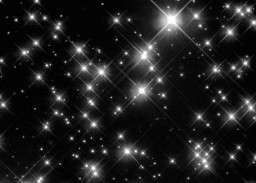

In [17]:
from PIL import Image
img = Image.open('stars_scaled.jpg').convert('L')
img

In [18]:
img_matrix = np.uint8(img.getdata()).reshape(img.size[::-1])
img_matrix.shape

(183, 256)

## Sklearn NMF

In [19]:
%%time

sklearn_nmf = SklearnNmf(n_components=10, tol=1e-5, max_iter=int(1e9))

W = sklearn_nmf.fit_transform(img_matrix)
H = sklearn_nmf.components_

CPU times: user 374 ms, sys: 560 ms, total: 934 ms
Wall time: 262 ms


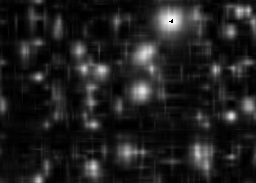

In [20]:
Image.fromarray(np.uint8(W.dot(H)), 'L')

## Gensim NMF

In [21]:
np.random.seed(42)

img_corpus = matutils.Dense2Corpus(img_matrix[np.random.choice(img_matrix.shape[0], img_matrix.shape[0], replace=False)].T)

In [22]:
%%time

import itertools

gensim_nmf = GensimNmf(
    img_corpus,
    chunksize=40,
    num_topics=10,
    passes=1,
    id2word={k: k for k in range(img_matrix.shape[1])},
    lambda_=1000,
    kappa=1,
    normalize=False
)

2018-08-20 22:15:22,726 : INFO : h_r_error: 17211892.5
2018-08-20 22:15:22,729 : INFO : h_r_error: 12284515.111163257
2018-08-20 22:15:22,731 : INFO : h_r_error: 11201387.638214733
2018-08-20 22:15:22,734 : INFO : h_r_error: 10815579.549704548
2018-08-20 22:15:22,738 : INFO : h_r_error: 10646539.06006998
2018-08-20 22:15:22,747 : INFO : h_r_error: 10558409.831047071
2018-08-20 22:15:22,755 : INFO : h_r_error: 10507775.272428757
2018-08-20 22:15:22,757 : INFO : h_r_error: 10475469.606854783
2018-08-20 22:15:22,759 : INFO : h_r_error: 10453925.335400445
2018-08-20 22:15:22,762 : INFO : h_r_error: 10439939.102116534
2018-08-20 22:15:22,784 : INFO : w_error: 10430366.610691467
2018-08-20 22:15:22,788 : INFO : w_error: 11466405.186009312
2018-08-20 22:15:22,791 : INFO : w_error: 10938537.274967317
2018-08-20 22:15:22,793 : INFO : w_error: 10835183.946454465
2018-08-20 22:15:22,799 : INFO : w_error: 10808896.588521175
2018-08-20 22:15:22,803 : INFO : w_error: 10800700.69189361
2018-08-20 22:

2018-08-20 22:15:23,774 : INFO : w_error: 2366899.5684030103
2018-08-20 22:15:23,780 : INFO : w_error: 2347964.180692087
2018-08-20 22:15:23,787 : INFO : w_error: 2332331.149509242
2018-08-20 22:15:23,791 : INFO : w_error: 2319290.024670701
2018-08-20 22:15:23,794 : INFO : w_error: 2308301.644607859
2018-08-20 22:15:23,811 : INFO : w_error: 2298998.176426708
2018-08-20 22:15:23,814 : INFO : w_error: 2291054.8383098356
2018-08-20 22:15:23,818 : INFO : w_error: 2284233.8267418565
2018-08-20 22:15:23,821 : INFO : w_error: 2278346.4815429775
2018-08-20 22:15:23,823 : INFO : w_error: 2273239.326070163
2018-08-20 22:15:23,824 : INFO : w_error: 2268800.1953844256
2018-08-20 22:15:23,826 : INFO : w_error: 2264918.837606525
2018-08-20 22:15:23,828 : INFO : w_error: 2261511.2618650706
2018-08-20 22:15:23,830 : INFO : w_error: 2258510.001427239
2018-08-20 22:15:23,831 : INFO : w_error: 2255858.510132532
2018-08-20 22:15:23,833 : INFO : w_error: 2253518.01968442
2018-08-20 22:15:23,834 : INFO : w_

CPU times: user 1.3 s, sys: 1.91 s, total: 3.22 s
Wall time: 1.63 s


In [23]:
W = gensim_nmf.get_topics().T
H = np.hstack(gensim_nmf[bow] for bow in matutils.Dense2Corpus(img_matrix.T))

2018-08-20 22:15:24,333 : INFO : h_r_error: 1641779.1711565189
2018-08-20 22:15:24,335 : INFO : h_r_error: 118028.68383364937
2018-08-20 22:15:24,337 : INFO : h_r_error: 105616.73503369163
2018-08-20 22:15:24,339 : INFO : h_r_error: 105376.48023111676
2018-08-20 22:15:24,344 : INFO : h_r_error: 105376.48023111676
2018-08-20 22:15:24,345 : INFO : h_r_error: 88296.81129174746
2018-08-20 22:15:24,347 : INFO : h_r_error: 75598.49700209008
2018-08-20 22:15:24,350 : INFO : h_r_error: 75202.00810070324
2018-08-20 22:15:24,352 : INFO : h_r_error: 75202.00810070324
2018-08-20 22:15:24,353 : INFO : h_r_error: 40896.39022296863
2018-08-20 22:15:24,354 : INFO : h_r_error: 32494.67090191547
2018-08-20 22:15:24,356 : INFO : h_r_error: 32239.868252556797
2018-08-20 22:15:24,366 : INFO : h_r_error: 32239.868252556797
2018-08-20 22:15:24,368 : INFO : h_r_error: 44930.159607806534
2018-08-20 22:15:24,370 : INFO : h_r_error: 36557.7492240496
2018-08-20 22:15:24,371 : INFO : h_r_error: 35312.9484972738
20

2018-08-20 22:15:24,658 : INFO : h_r_error: 134685.80489629053
2018-08-20 22:15:24,661 : INFO : h_r_error: 113538.95669792594
2018-08-20 22:15:24,665 : INFO : h_r_error: 113353.41144229252
2018-08-20 22:15:24,669 : INFO : h_r_error: 113353.41144229252
2018-08-20 22:15:24,671 : INFO : h_r_error: 122345.42442740352
2018-08-20 22:15:24,672 : INFO : h_r_error: 101206.04117840753
2018-08-20 22:15:24,673 : INFO : h_r_error: 100993.62587045786
2018-08-20 22:15:24,674 : INFO : h_r_error: 100993.62587045786
2018-08-20 22:15:24,676 : INFO : h_r_error: 116266.06525752878
2018-08-20 22:15:24,677 : INFO : h_r_error: 96812.1429100881
2018-08-20 22:15:24,683 : INFO : h_r_error: 96671.85729303533
2018-08-20 22:15:24,686 : INFO : h_r_error: 96671.85729303533
2018-08-20 22:15:24,687 : INFO : h_r_error: 124976.11247413699
2018-08-20 22:15:24,689 : INFO : h_r_error: 105696.72347766797
2018-08-20 22:15:24,690 : INFO : h_r_error: 105516.7395837665
2018-08-20 22:15:24,691 : INFO : h_r_error: 105516.739583766

2018-08-20 22:15:25,015 : INFO : h_r_error: 58344.200783367785
2018-08-20 22:15:25,020 : INFO : h_r_error: 56997.1979143896
2018-08-20 22:15:25,023 : INFO : h_r_error: 56864.86772938072
2018-08-20 22:15:25,025 : INFO : h_r_error: 56864.86772938072
2018-08-20 22:15:25,031 : INFO : h_r_error: 55804.84516396389
2018-08-20 22:15:25,032 : INFO : h_r_error: 49720.76312800324
2018-08-20 22:15:25,034 : INFO : h_r_error: 48669.3293093283
2018-08-20 22:15:25,036 : INFO : h_r_error: 48566.79973146436
2018-08-20 22:15:25,039 : INFO : h_r_error: 48566.79973146436
2018-08-20 22:15:25,042 : INFO : h_r_error: 50232.78247908833
2018-08-20 22:15:25,045 : INFO : h_r_error: 43460.18499959944
2018-08-20 22:15:25,047 : INFO : h_r_error: 42583.76639804095
2018-08-20 22:15:25,049 : INFO : h_r_error: 42583.76639804095
2018-08-20 22:15:25,051 : INFO : h_r_error: 70689.83802178742
2018-08-20 22:15:25,053 : INFO : h_r_error: 54799.329874802635
2018-08-20 22:15:25,057 : INFO : h_r_error: 53914.8316747843
2018-08-2

2018-08-20 22:15:25,356 : INFO : h_r_error: 123923.46378028487
2018-08-20 22:15:25,357 : INFO : h_r_error: 91401.7915719367
2018-08-20 22:15:25,359 : INFO : h_r_error: 85191.39582673303
2018-08-20 22:15:25,361 : INFO : h_r_error: 84532.90616743342
2018-08-20 22:15:25,364 : INFO : h_r_error: 84532.90616743342
2018-08-20 22:15:25,365 : INFO : h_r_error: 111957.92974291708
2018-08-20 22:15:25,367 : INFO : h_r_error: 90673.10717043538
2018-08-20 22:15:25,368 : INFO : h_r_error: 86795.48708018255
2018-08-20 22:15:25,370 : INFO : h_r_error: 86359.0193082306
2018-08-20 22:15:25,372 : INFO : h_r_error: 86359.0193082306
2018-08-20 22:15:25,374 : INFO : h_r_error: 78116.94232451699
2018-08-20 22:15:25,389 : INFO : h_r_error: 64864.185952766085
2018-08-20 22:15:25,403 : INFO : h_r_error: 62627.20138398043
2018-08-20 22:15:25,406 : INFO : h_r_error: 62387.88488623845
2018-08-20 22:15:25,417 : INFO : h_r_error: 62387.88488623845
2018-08-20 22:15:25,418 : INFO : h_r_error: 49500.7753928332
2018-08-2

2018-08-20 22:15:25,908 : INFO : h_r_error: 20608.810430887163
2018-08-20 22:15:25,910 : INFO : h_r_error: 20433.54257729559
2018-08-20 22:15:25,911 : INFO : h_r_error: 20400.741509122505
2018-08-20 22:15:25,913 : INFO : h_r_error: 20400.741509122505
2018-08-20 22:15:25,916 : INFO : h_r_error: 28200.31679054761
2018-08-20 22:15:25,919 : INFO : h_r_error: 23300.098733814248
2018-08-20 22:15:25,929 : INFO : h_r_error: 22137.1510942318
2018-08-20 22:15:25,931 : INFO : h_r_error: 21810.085864093246
2018-08-20 22:15:25,932 : INFO : h_r_error: 21775.213278946343
2018-08-20 22:15:25,934 : INFO : h_r_error: 21775.213278946343
2018-08-20 22:15:25,935 : INFO : h_r_error: 15260.366709589653
2018-08-20 22:15:25,936 : INFO : h_r_error: 11872.08315938859
2018-08-20 22:15:25,937 : INFO : h_r_error: 10908.905597899073
2018-08-20 22:15:25,938 : INFO : h_r_error: 10684.630020773682
2018-08-20 22:15:25,939 : INFO : h_r_error: 10651.271246929588
2018-08-20 22:15:25,941 : INFO : h_r_error: 10651.2712469295

2018-08-20 22:15:26,250 : INFO : h_r_error: 89193.15992567304
2018-08-20 22:15:26,251 : INFO : h_r_error: 82326.7193949022
2018-08-20 22:15:26,253 : INFO : h_r_error: 81654.10188430984
2018-08-20 22:15:26,254 : INFO : h_r_error: 81550.8364588384
2018-08-20 22:15:26,256 : INFO : h_r_error: 81550.8364588384
2018-08-20 22:15:26,258 : INFO : h_r_error: 195202.30314943343
2018-08-20 22:15:26,259 : INFO : h_r_error: 87377.33791727532
2018-08-20 22:15:26,261 : INFO : h_r_error: 80672.67496760779
2018-08-20 22:15:26,262 : INFO : h_r_error: 80479.76631168138
2018-08-20 22:15:26,268 : INFO : h_r_error: 80479.76631168138
2018-08-20 22:15:26,271 : INFO : h_r_error: 144824.23872960033
2018-08-20 22:15:26,272 : INFO : h_r_error: 55900.50694270172
2018-08-20 22:15:26,273 : INFO : h_r_error: 50456.945266342926
2018-08-20 22:15:26,275 : INFO : h_r_error: 50209.455574301464
2018-08-20 22:15:26,277 : INFO : h_r_error: 50209.455574301464
2018-08-20 22:15:26,278 : INFO : h_r_error: 120497.96569875091
2018-

2018-08-20 22:15:26,582 : INFO : h_r_error: 18959.722842143907
2018-08-20 22:15:26,583 : INFO : h_r_error: 83876.31226742358
2018-08-20 22:15:26,584 : INFO : h_r_error: 27066.441250717817
2018-08-20 22:15:26,586 : INFO : h_r_error: 23671.276967366928
2018-08-20 22:15:26,587 : INFO : h_r_error: 23588.035853516478
2018-08-20 22:15:26,590 : INFO : h_r_error: 23588.035853516478
2018-08-20 22:15:26,591 : INFO : h_r_error: 87851.09522030315
2018-08-20 22:15:26,593 : INFO : h_r_error: 36557.55519906569
2018-08-20 22:15:26,596 : INFO : h_r_error: 32920.158554937225
2018-08-20 22:15:26,605 : INFO : h_r_error: 32884.0633641823


### Reconstructed matrix:

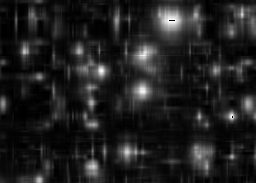

In [24]:
Image.fromarray(np.uint8(W.dot(H).T), 'L')